# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: дробное число - это вероятность принадлежности прогноза к положительному классу (1). В зависимости от способа округления (порога) мы делаем вывод о принадлежности прогноза к тому или иному классу, т.е переводим дорбь в $\{ 0, 1\}$

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


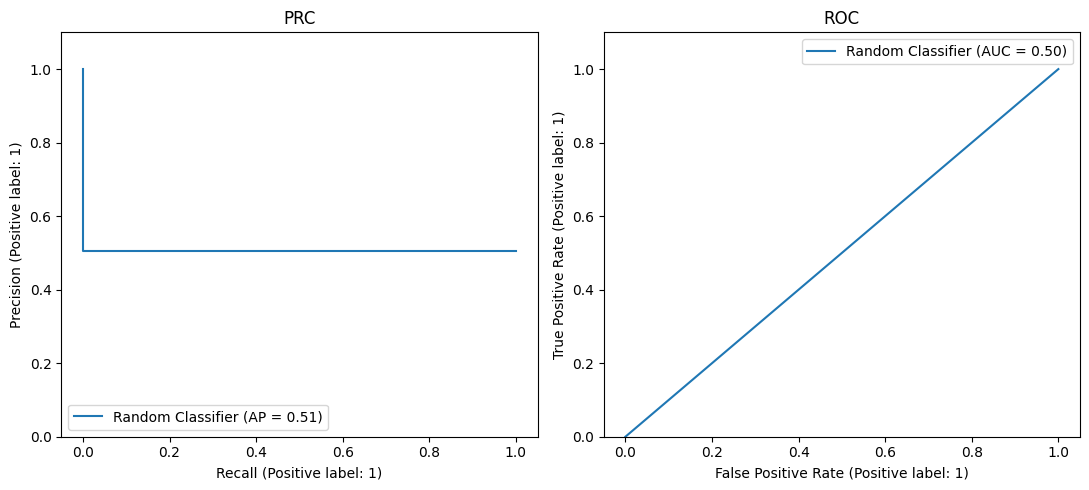

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
params_grid = {'C': np.logspace(-3, 2, 10)}
model = LinearSVC(max_iter = 1000000)
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=3, scoring='average_precision', verbose = 1)
grid_search.fit(X_train, y_train)
print(f'best params: {grid_search.best_params_}, best AUC-PR: {grid_search.best_score_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best params: {'C': 0.5994842503189409}, best AUC-PR: 0.822656787450725


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Linear SVM metrics
AUC-PR: 0.82961
AUC-ROC: 0.84762


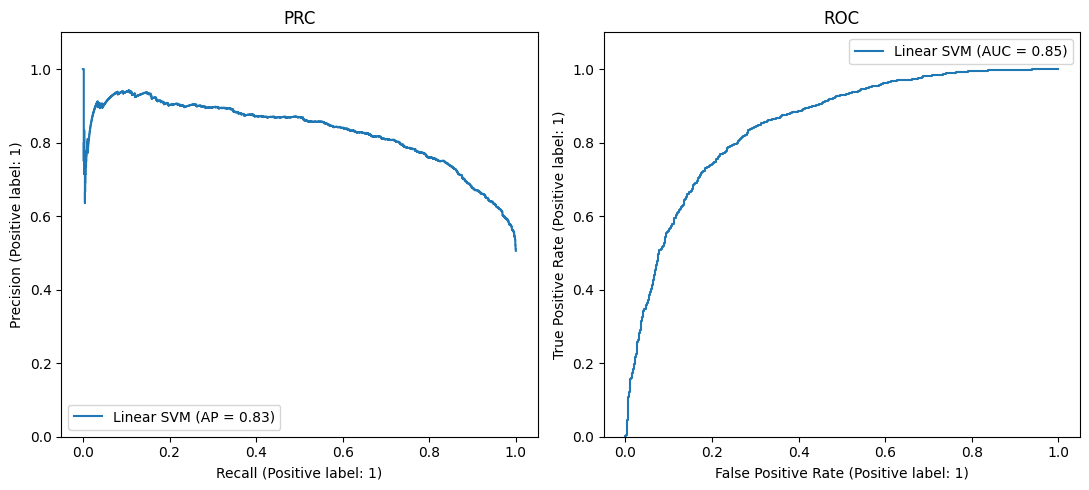

In [ ]:
SVC = LinearSVC(max_iter = 1000000, C = grid_search.best_params_['C'])
SVC.fit(X_train, y_train)
y_pred_svc = SVC.decision_function(X_test)
depict_pr_roc(y_test, y_pred_svc, 'Linear SVC')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


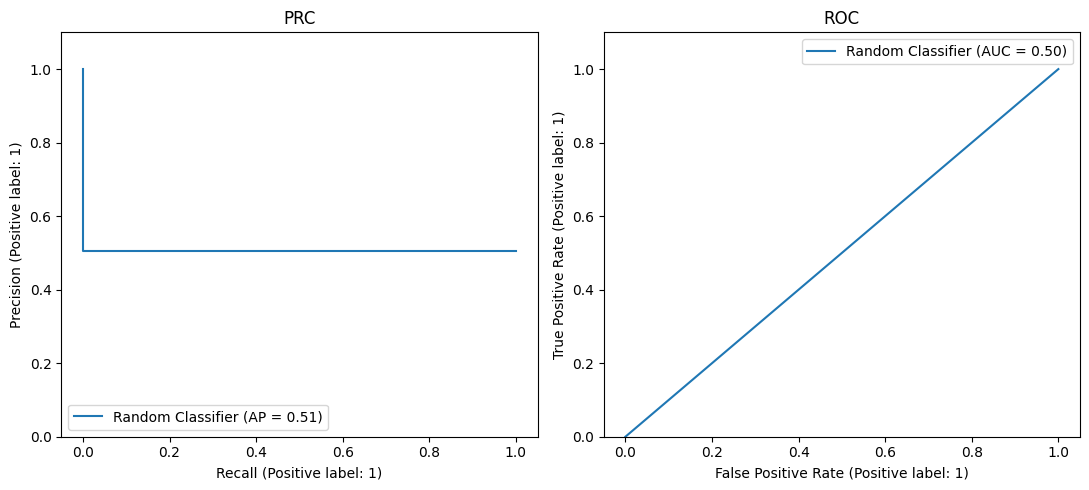

In [ ]:
y_random = random_classifier.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, y_random, 'Random Classifier')

__Обе метрики у SVM лучше, чем у рандома, что логично)__

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression
params_grid = {'C': np.logspace(-3, 2, 10)}
model = LogisticRegression(penalty='l2')
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, scoring='average_precision', verbose = 3)
grid_search.fit(X_train, y_train)
print(f'best params: {grid_search.best_params_}, best AUC-PR: {grid_search.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...........................C=0.001;, score=0.827 total time=   0.1s
[CV 2/5] END ...........................C=0.001;, score=0.816 total time=   0.1s
[CV 3/5] END ...........................C=0.001;, score=0.844 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.820 total time=   0.1s
[CV 5/5] END ...........................C=0.001;, score=0.832 total time=   0.0s
[CV 1/5] END ............C=0.003593813663804626;, score=0.825 total time=   0.0s
[CV 2/5] END ............C=0.003593813663804626;, score=0.815 total time=   0.0s
[CV 3/5] END ............C=0.003593813663804626;, score=0.840 total time=   0.1s
[CV 4/5] END ............C=0.003593813663804626;, score=0.816 total time=   0.1s
[CV 5/5] END ............C=0.003593813663804626;, score=0.828 total time=   0.1s
[CV 1/5] END .............C=0.01291549665014884;, score=0.824 total time=   0.1s
[CV 2/5] END .............C=0.01291549665014884;

In [ ]:
LR = LogisticRegression(penalty = 'l2', C = grid_search.best_params_['C'])
LR.fit(X_train, y_train)
y_pred_lr = LR.decision_function(X_test)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Linear SVC metrics
AUC-PR: 0.82961
AUC-ROC: 0.84762
Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
Logistic Regression metrics
AUC-PR: 0.83360
AUC-ROC: 0.84534


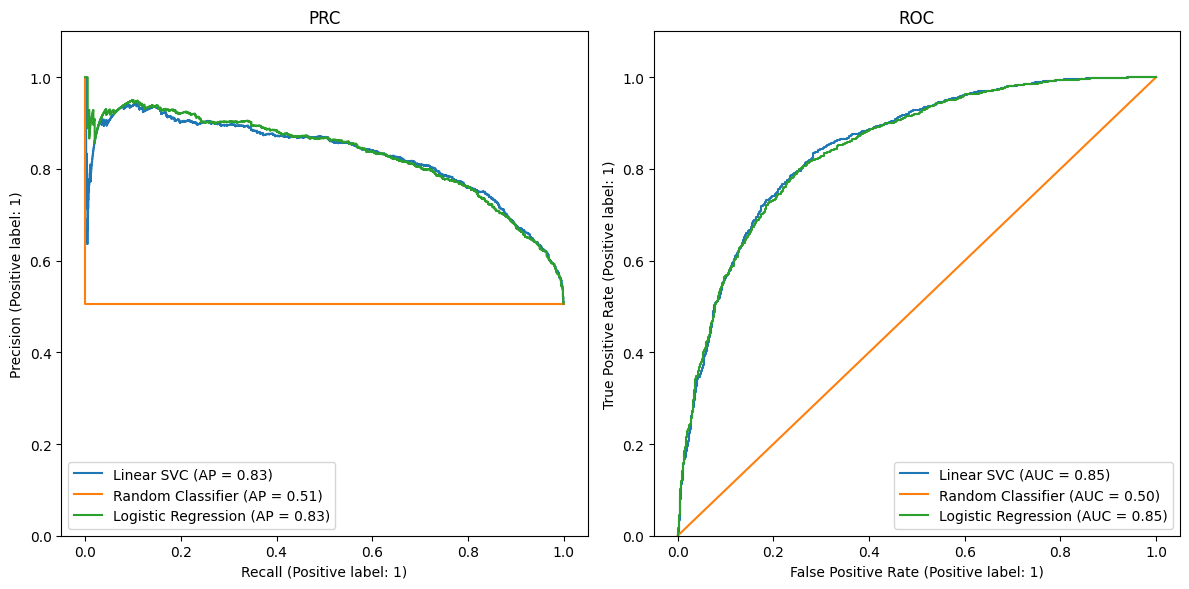

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
depict_pr_roc(y_test, y_pred_svc, 'Linear SVC', ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_pred_lr, 'Logistic Regression', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** __Показатели обеих моделей почти одинаковые, однако SVM обучается сильно дольше, особенно на больших C__

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
from sklearn.svm import SVC
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant = 0, random_state=42)
model = SVC(kernel = 'linear')
model.fit(X, y)

SVC(kernel='linear')

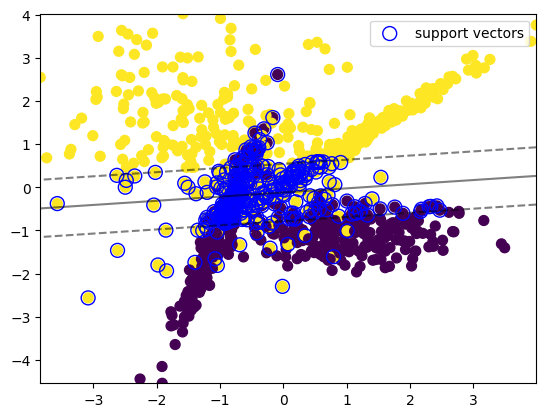

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 50
                )

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорными выделяются объекты, которые оказывают наиольнее влияние на определение гиперплоскости SVM. Они находятся в другом классе и находятся на или за границей

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l2')
model.fit(X, y)

LogisticRegression()

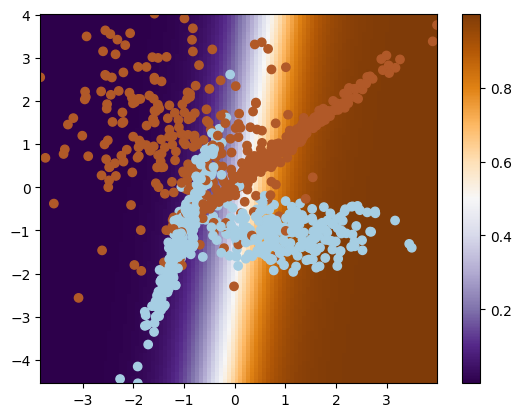

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1].reshape((xx.shape[0], -1)).T
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Это белая область - здесь "расстояние" до обоих классов у модели одинаковое и она не уверена, к какому классу ближе можно отнести предсказание

 #### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

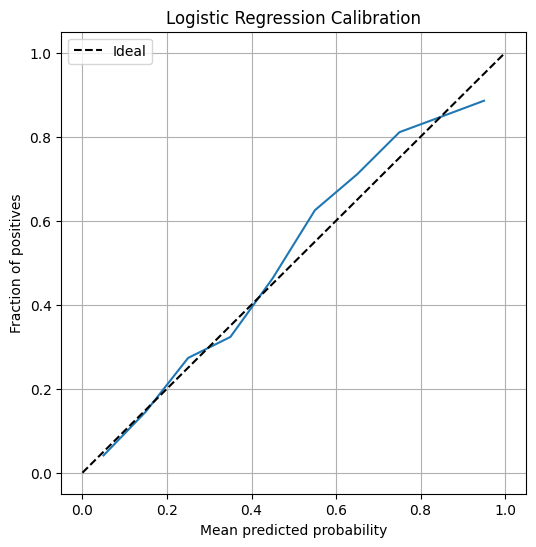

In [ ]:
lr_model = LogisticRegression(penalty = 'l2')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_pred)
plt.title('Logistic Regression Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()

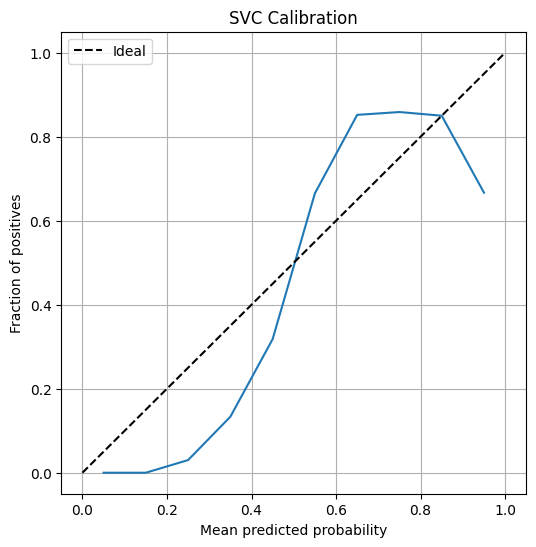

In [ ]:
svc_model = SVC(kernel = 'linear', max_iter = 100000, C = 0.01)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, svc_pred)
plt.title('SVC Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Для Логистической регрессии довольно неплохо откалиброваны, для SVM слабовато

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

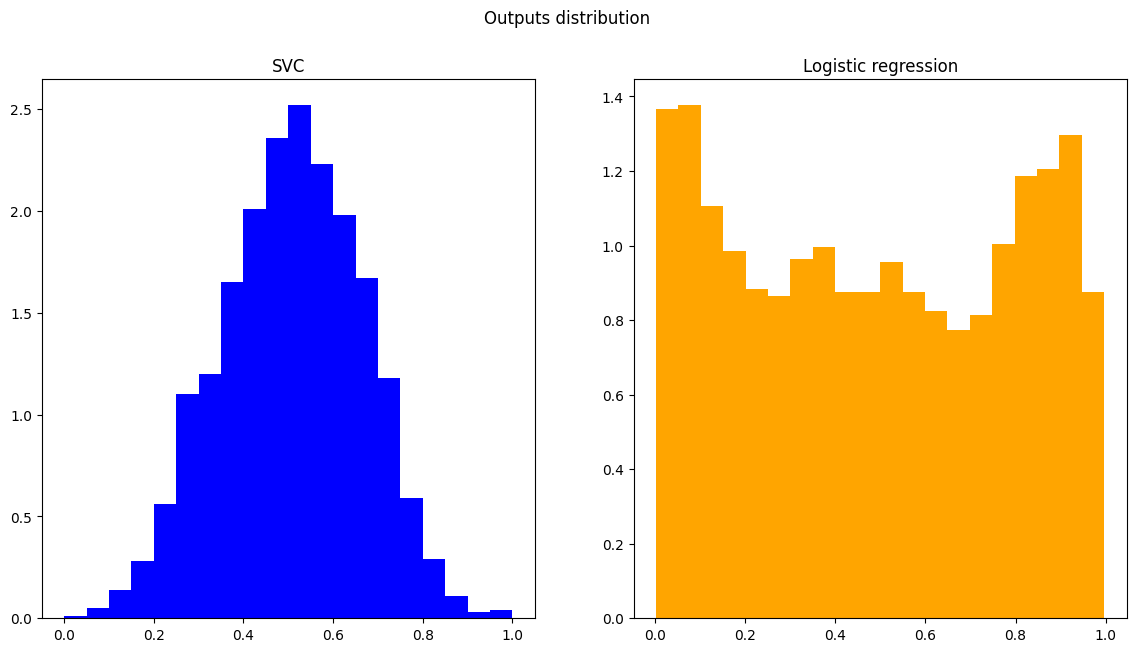

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Логистическая регрессия более уверена в своих результатах, т.к. наибольшая плотность - в концах, SVM же наоборот, в большинстве объектов не уверен, соответственно, такое и распределение

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

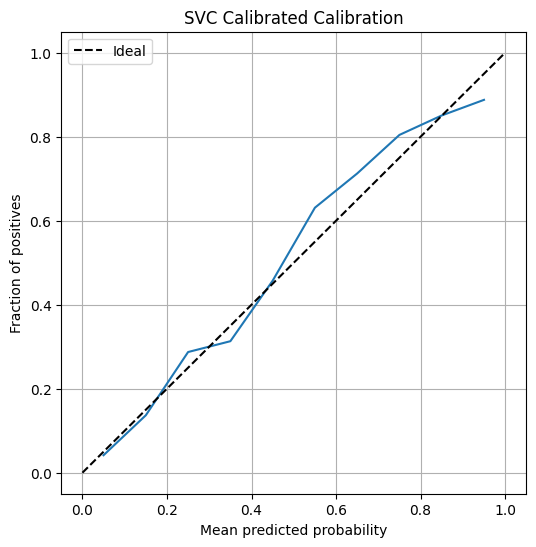

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
svc_calib = CalibratedClassifierCV(LinearSVC(max_iter=1000, C=0.1))
svc_calib.fit(X_train, y_train)
svc_calib_pred = svc_calib.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, svc_calib_pred)
plt.title('SVC Calibrated Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Да, улучшилась

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
df = pd.read_csv('bike_buyers.csv')

categorical_columns = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike']
df[categorical_columns] = df[categorical_columns].fillna('undefined')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    1000 non-null   object 
 2   Gender            1000 non-null   object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        1000 non-null   object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [ ]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
categorical_columns = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike']
df[categorical_columns] = df[categorical_columns].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_categorical = X[['Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.linear_model import LogisticRegression

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression()
start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.5728774226351424
Training Time: 0.0066335201263427734 seconds


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression(penalty = 'l2', C = 0.1)
start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.673386440793486
Training Time: 0.019118785858154297 seconds


__AUC-PR у OHE увеличился по сравнению с OE, время кодирования тоже увеличилось__

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
start = time.time()
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
for column in X_train.columns:
  column_dict = {}
  for category in X_train[column].unique():
    column_dict[category] = ((X_train[column] == category) & (y_train == 1)).sum() / ((X_train[column] == category).sum() + 1)
  X_train_encoded[column] = X_train[column].map(column_dict)
  X_test_encoded[column] = X_test[column].map(column_dict)
model = LogisticRegression(penalty = 'l2', C = 10**9)
model.fit(X_train_encoded, y_train)
end = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.6940401186235012
Training Time: 0.019118785858154297 seconds


__Cкор выше, чем у One Hot__

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code):
        self.columns_to_code = columns_to_code

    def fit(self, X, y):
        self.categoric_dict = dict()
        for column in self.columns_to_code:
            column_dict = dict()
            for category in  pd.unique(X[column]):
                column_dict[category] = ((X[column] == category) & (y == 1)).sum() / ((X[column] == category).sum())
            self.categoric_dict[column] = column_dict
        return self

    def transform(self, X):
        for column in self.columns_to_code:
            X[column] = X[column].apply(lambda x: self.categoric_dict[column].get(x, 0))
        return X

In [ ]:
start_time = time.time()

my_encoder = MyEncoder(X_train.columns)
my_encoder.fit(X_train, y_train)

X_train_encoded = my_encoder.transform(X_train)
X_test_encoded = my_encoder.transform(X_test)
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.676015431442218
Training Time: 0.04106020927429199 seconds


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyEncoderNoise(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise):
        self.columns_to_code = columns_to_code
        self.noise = noise
    def fit(self, X, y):
        self.categoric_dict = dict()
        for column in self.columns_to_code:
            column_dict = dict()
            for category in  pd.unique(X[column]):
                column_dict[category] = ((X[column] == category) & (y == 1)).sum() / ((X[column] == category).sum()) + np.random.randn() * self.noise
            self.categoric_dict[column] = column_dict
        return self

    def transform(self, X):
        for column in self.columns_to_code:
            X[column] = X[column].apply(lambda x: self.categoric_dict[column].get(x, 0))
        return X

In [ ]:
np.random.seed(42)
start_time = time.time()

my_encoder = MyEncoderNoise(X_train.columns, 1e-2)
my_encoder.fit(X_train, y_train)

X_train_encoded = my_encoder.transform(X_train)
X_test_encoded = my_encoder.transform(X_test)
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.6803844666284244
Training Time: 0.040772199630737305 seconds


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума улчшило метрику, потому что он помогает бороться с обучением, обобщая предсказания модели, не давая ей сильно подогнаться под данные

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyEncoderNoiseVanilla(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise, C):
        self.columns_to_code = columns_to_code
        self.noise = noise
        self.C = C
    def fit(self, X, y):
        self.categoric_dict = dict()
        for column in self.columns_to_code:
            column_dict = dict()
            for category in  pd.unique(X[column]):
                column_dict[category] = (((X[column] == category) & (y == 1)).sum() + C * np.mean(y)) / ((X[column] == category).sum() + C) + np.random.randn() * self.noise
            self.categoric_dict[column] = column_dict
        return self

    def transform(self, X):
        for column in self.columns_to_code:
            X[column] = X[column].apply(lambda x: self.categoric_dict[column].get(x, 0))
        return X

In [ ]:
np.random.seed(42)
start_time = time.time()
best_score = -1
best_C = None
for C in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
  my_encoder = MyEncoderNoiseVanilla(X_train.columns, 1e-2, C)
  my_encoder.fit(X_train, y_train)

  X_train_encoded = my_encoder.transform(X_train)
  X_test_encoded = my_encoder.transform(X_test)
  model = LogisticRegression()
  model.fit(X_train_encoded, y_train)
  y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
  precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
  score = auc(recall, precision)

  if score > best_score:
    best_score = score
    best_C = C
end_time = time.time()
training_time = end_time - start_time

print(f"AUC-PR Score: { best_score}, Best C: {best_C}")
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.6837035195116073, Best C: 20
Training Time: 0.6082406044006348 seconds


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_numerical.isna().sum()

Income      6
Children    8
Cars        9
Age         8
dtype: int64

In [ ]:
for column in X_numerical.columns:
    X_numerical[column].fillna(X_numerical[column].mean(), inplace=True)

<ipython-input-69-ffe2c220f82a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical[column].fillna(X_numerical[column].mean(), inplace=True)


In [ ]:
X_numerical.isna().sum()

Income      0
Children    0
Cars        0
Age         0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
for column in X_numerical.columns:
  print(f'column: {column}, unique categories: {X[column].nunique()}')

column: Income, unique categories: 16
column: Children, unique categories: 6
column: Cars, unique categories: 5
column: Age, unique categories: 53


Income и Age содержат в себе много признаков: 16 и 53. Поэтому для них OHE было бы не очень делать

In [ ]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

start_time = time.time()
best_score = -1
best_C = None

for C in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
  my_encoder = MyEncoderNoiseVanilla(X_train.columns, 1e-2, C)
  my_encoder.fit(X_train, y_train)

  X_train_encoded = my_encoder.transform(X_train)
  X_test_encoded = my_encoder.transform(X_test)
  model = LogisticRegression()
  model.fit(X_train_encoded, y_train)
  y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
  precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
  score = auc(recall, precision)

  if score > best_score:
    best_score = score
    best_C = C
end_time = time.time()
training_time = end_time - start_time

print(f"AUC-PR Score: { best_score}, Best C: {best_C}")
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.7039959174212351, Best C: 50
Training Time: 6.579921722412109 seconds


__Стало!__

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

__Плюсы:__
- OНЕ слаб, когда данные разрежены, то есть когда у нас признаку соответствует мало значений (мало единичек в столбце).
- Cчетчики более скореллированы с таргетом, OHE же никак не связан

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-24 07:31:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [ <=>                ]   3.79M  --.-KB/s    in 0.1s    

2023-11-24 07:31:37 (26.8 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
3705,43,Private,76487,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()
X_train_encoded.shape[1]

102

In [ ]:
X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)

AUC-PR Score: 0.4503322041518036


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
import time
start_time = time.time()

X_train_40bestfeatures = X_train.iloc[:, model.coef_[0].argsort()[-40:]]
X_test_40bestfeatures = X_test.iloc[:, model.coef_[0].argsort()[-40:]]

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 100)
model.fit(X_train_40bestfeatures, y_train)
y_pred_prob = model.predict_proba(X_test_40bestfeatures)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

end_time = time.time()
training_time = end_time - start_time

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score 0.7370448453114243
Training Time: 2.051464557647705 seconds


Изменилось ли качество? Как?

__Качество практически не изменилось, на несколько стотысячных увеличилось__



Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]).toarray())
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]).toarray())
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]))
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_features]))
X_train_scaled.columns = numeric_features
X_test_scaled.columns = numeric_features

X_train = X_train_scaled.join(X_train_encoded)
X_test = X_test_scaled.join(X_test_encoded)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 100)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")


AUC-PR Score 0.7661528019230469
Training Time: 2.051464557647705 seconds


__Качество заметно улучшилось__

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]).toarray())
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]).toarray())
X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 10)
model.fit(X_train_scaled, y_train)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score", score)

AUC-PR Score 0.7659620921134596


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
df_train = X_train.join(y_train)

In [ ]:
start_time = time.time()
t_columns = {}

for column in df_train.columns:
  if column == 'income':
    continue
  mu_plus = np.mean(df_train[df_train['income'] == 1][column])
  mu_minus = np.mean(df_train[df_train['income'] == 0][column])
  std_plus = np.std(df_train[df_train['income'] == 1][column])
  std_minus = np.std(df_train[df_train['income'] == 0][column])
  n_plus =len(df_train[df_train['income'] == 1][column])
  n_minus= len(df_train[df_train['income'] == 0][column])
  if (n_plus * (std_plus ** 2) + n_minus * (std_minus ** 2)) / (n_plus + n_minus) == 0:
    continue
  t_column = np.abs(mu_plus - mu_minus) / ((n_plus * (std_plus ** 2) + n_minus * (std_minus ** 2)) / (n_plus + n_minus))
  t_columns[column] = t_column

t_columns_40bestfeatures = sorted(t_columns, key=t_columns.get)[-40:]
X_train_40bestfeatures = X_train[t_columns_40bestfeatures]
X_test_40bestfeatures = X_test[t_columns_40bestfeatures]
end_time = time.time()

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 10)
model.fit(X_train_40bestfeatures, y_train)
y_pred_prob = model.predict_proba(X_test_40bestfeatures)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
training_time = end_time - start_time

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score 0.4279575566783917
Training Time: 3.888808250427246 seconds


__Времени занимает немало, хотя всего 100 признаков, а качество низкое (0.58)__

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
from tqdm.notebook import tqdm

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777)
X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()
X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_val = X_val[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_val_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

start_time = time.time()
encoder = OneHotEncoder()
model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)

progress_bar = tqdm(range(len(X_train.columns), 39, -1))
while len(X_train.columns) > 40:
  progress_bar.set_description(f"Current number of columns: {len(X_train.columns)}")

  worst_score = 2
  worst_column = None

  for column in X_train.columns:
    X_train_drop_feature = X_train.drop(column, axis = 1)
    X_val_drop_feature = X_val.drop(column, axis = 1)
    model.fit(X_train_drop_feature, y_train)
    y_pred_prob = model.predict_proba(X_val_drop_feature)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    score = auc(recall, precision)

    if score < worst_score:
      worst_score = score
      worst_column = column

  X_train = X_train.drop(worst_column, axis = 1)
  X_val = X_val.drop(worst_column, axis = 1)

progress_bar.set_description(f"Current number of columns: {len(X_train.columns)}")
progress_bar.close()
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

  0%|          | 0/69 [00:00<?, ?it/s]

Training Time: 423.83034229278564 seconds


In [ ]:
X_test = X_test[X_train.columns]
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
print("AUC-PR Score", max(score, 1 - score))

AUC-PR Score 0.7571928256174717


In [99]:
from tqdm.notebook import tqdm

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_val = X_val[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_val_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))

X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train_1 = X_train.copy()

start_time = time.time()
encoder = OneHotEncoder()
model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)
best_columns = []

progress_bar = tqdm(range(0, 40, 1))
while len(best_columns) < 40:
  progress_bar.set_description(f"Current number of columns: {len(best_columns)}")

  best_score = -1
  best_column = None

  for column in X_train.columns:
    model.fit(np.array([X_train[column]]).T, y_train)
    y_pred_prob = model.predict_proba(np.array([X_val[column]]).T)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    score = auc(recall, precision)

    if score > best_score:
      best_score = score
      best_column = column

  best_columns.append(best_column)
  X_train = X_train.drop(best_column, axis = 1)
progress_bar.set_description(f"Current number of columns: {len(best_columns)}")
progress_bar.close()
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Training Time: 79.772043466568 seconds


In [100]:
X_train_1 = X_train_1[best_columns]
X_val = X_val[best_columns]
X_test = X_test[best_columns]
model.fit(X_train_1, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
print("AUC-PR Score", max(score, 1 - score))

AUC-PR Score 0.6601079200062848


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Наилучшее качество дало отсечение одного признака, т.к. мы смотрели на модель в общем, а не по отдельности по каждому признаку, когда выбирал 40 лучших, поэтому на модели с отсечением и качество лучше

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [7]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-24 12:16:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.1’

bank-additional.zip     [  <=>               ] 434.15K  1.45MB/s    in 0.3s    

2023-11-24 12:16:23 (1.45 MB/s) - ‘bank-additional.zip.1’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [22]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = ['age', 'pdays', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

preds_dict = {}

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter = 10000))
])
i = 0
for train_i, test_i in kfold.split(X, y):
  i += 1
  X_train = X.loc[train_i]
  y_train = y.loc[train_i]
  X_test = X.loc[test_i]
  y_test = y.loc[test_i]

  model = pipeline.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  preds_dict[f'{i} fold'] = y_pred

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [48]:
i = 0
incomes = []
costs = []
profits = []

for train_i, test_i in kfold.split(X, y):
  i += 1
  y_pred = preds_dict[f'{i} fold']
  y_test = y.loc[test_i].values
  income = 10 * np.sum((y_pred == 1) & (y_test == 1))
  cost = 1 * np.sum(y_pred)
  profit = income - cost
  incomes.append(income)
  costs.append(cost)
  profits.append(profit)

print('-'* 50)
print(f"income| mean: {np.mean(incomes)} | std: {np.std(incomes)}")
print('-'* 50)
print(f"cost  | mean: {np.mean(costs)}  | std: {np.std(costs)}")
print('-'* 50)
print(f"profit| mean: {np.mean(profits)} | std: {np.std(profits)}")
print('-'* 50)

--------------------------------------------------
income| mean: 2124.0 | std: 103.84603988597736
--------------------------------------------------
cost  | mean: 322.8  | std: 7.19444229944198
--------------------------------------------------
profit| mean: 1801.2 | std: 104.83396396206717
--------------------------------------------------


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [61]:
i = 0
incomes = []
costs = []
profits = []

for train_i, test_i in kfold.split(X, y):
  i += 1
  y_pred = preds_dict[f'{i} fold']
  y_test = y.loc[test_i].values
  value = np.random.uniform(0, 20, len((y_pred == 1) & (y_test == 1)))
  income = np.sum(value * ((y_pred == 1) & (y_test == 1)))
  cost = 1 * np.sum(y_pred)
  profit = income - cost
  incomes.append(income)
  costs.append(cost)
  profits.append(profit)

print('-'* 50)
print(f"income| mean: {np.mean(incomes)} | std: {np.std(incomes)}")
print('-'* 50)
print(f"cost  | mean: {np.mean(costs)}  | std: {np.std(costs)}")
print('-'* 50)
print(f"profit| mean: {np.mean(profits)} | std: {np.std(profits)}")
print('-'* 50)

--------------------------------------------------
income| mean: 2079.882068183354 | std: 67.27796078393874
--------------------------------------------------
cost  | mean: 322.8  | std: 7.19444229944198
--------------------------------------------------
profit| mean: 1757.0820681833543 | std: 68.06613783065828
--------------------------------------------------


__Прибыль уменьшилась, но стандартное отклонение тоже сильно уменьшилось, т.е. прибыль стала более определенной__

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

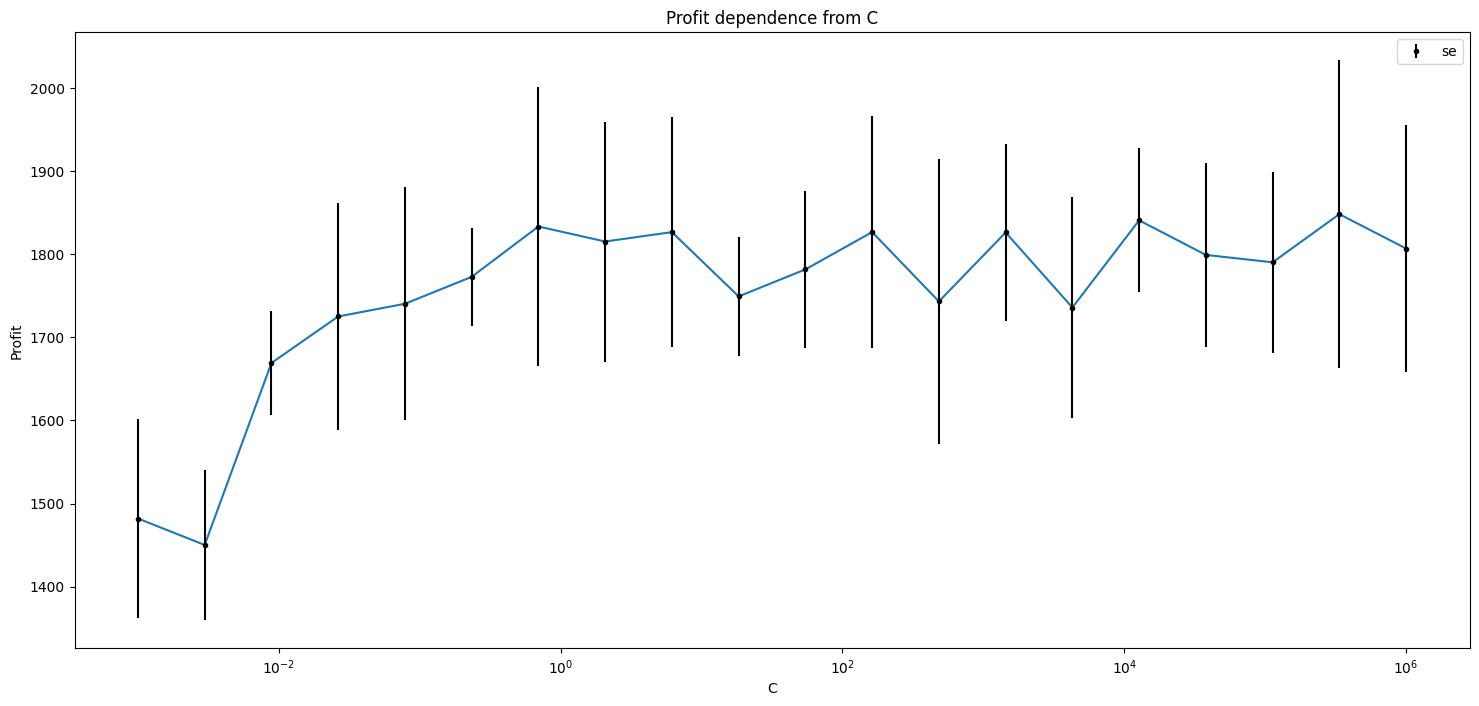

In [98]:
profits_mean  = []
profits_std  = []

for C in np.logspace(-3, 6, 20):
  preds_dict = {}
  column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

  pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', LogisticRegression(max_iter = 10000, C = C))
  ])
  i = 0
  for train_i, test_i in kfold.split(X, y):
    i += 1
    X_train = X.loc[train_i]
    y_train = y.loc[train_i]
    X_test = X.loc[test_i]
    y_test = y.loc[test_i]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds_dict[f'{i} fold'] = y_pred


  i = 0
  incomes = []
  costs = []
  profits = []

  for train_i, test_i in kfold.split(X, y):
    i += 1
    y_pred = preds_dict[f'{i} fold']
    y_test = y.loc[test_i].values

    value = np.random.uniform(0, 20, len((y_pred == 1) & (y_test == 1)))
    income = np.sum(value * ((y_pred == 1) & (y_test == 1)))
    cost = 1 * np.sum(y_pred)
    profit = income - cost

    incomes.append(income)
    costs.append(cost)
    profits.append(profit)

  profits_mean.append(np.mean(profits))
  profits_std.append(np.std(profits))
fig, ax = plt.subplots(1, figsize=(18, 8))
ax.plot(np.logspace(-3, 6, 20), profits_mean)
ax.set_xlabel('C')
ax.set_ylabel('Profit')
ax.set_title('Profit dependence from C')
ax.set_xscale('log')

ax.errorbar(np.logspace(-3, 6, 20), profits_mean, yerr=profits_std, fmt='.k', label='se')
ax.legend()
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

  0%|          | 0/5 [00:00<?, ?it/s]

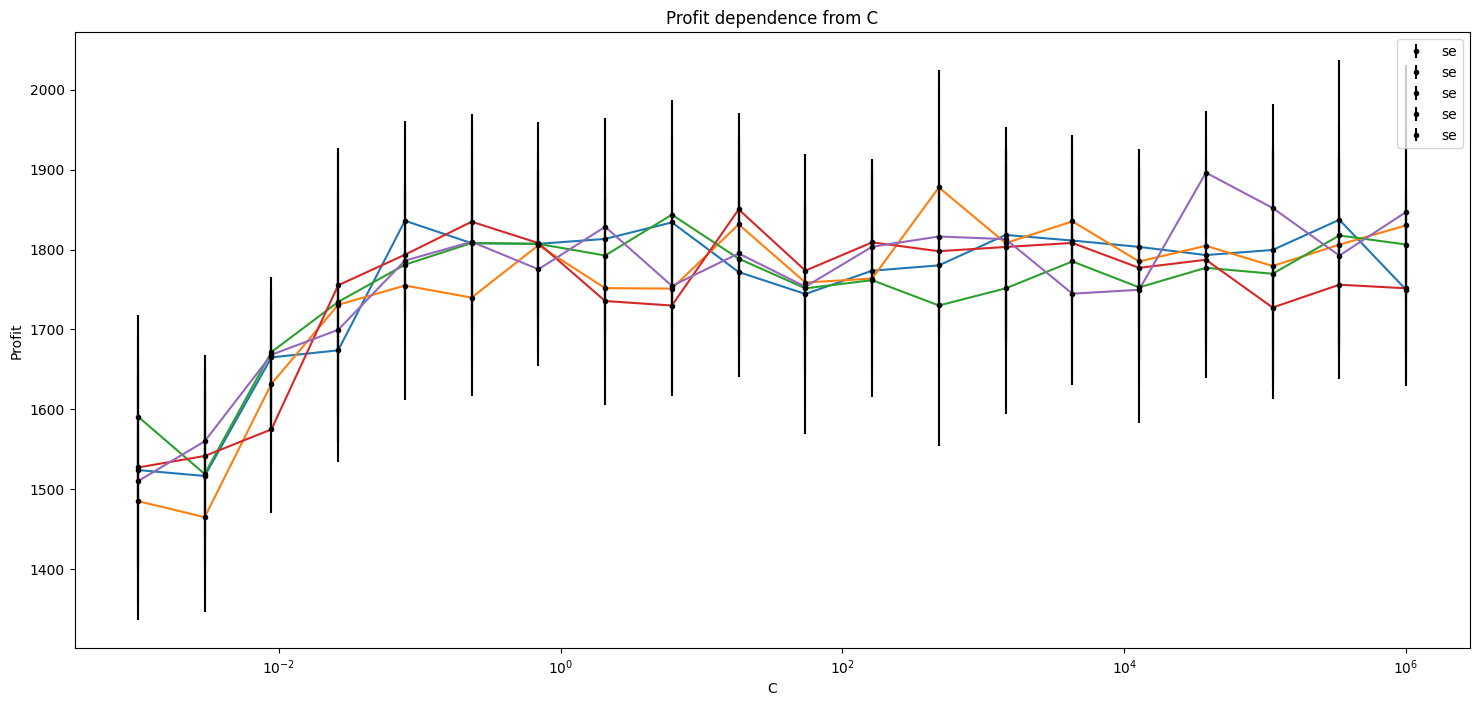

In [99]:
fig, ax = plt.subplots(1, figsize=(18, 8))
for _ in tqdm(range(5)):
  profits_mean  = []
  profits_std  = []

  for C in np.logspace(-3, 6, 20):
    preds_dict = {}
    column_transformer = ColumnTransformer([
      ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
      ('scaler', StandardScaler(), numeric_features)
  ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(max_iter = 10000, C = C))
    ])
    i = 0
    for train_i, test_i in kfold.split(X, y):
      i += 1
      X_train = X.loc[train_i]
      y_train = y.loc[train_i]
      X_test = X.loc[test_i]
      y_test = y.loc[test_i]

      model = pipeline.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      preds_dict[f'{i} fold'] = y_pred


    i = 0
    incomes = []
    costs = []
    profits = []

    for train_i, test_i in kfold.split(X, y):
      i += 1
      y_pred = preds_dict[f'{i} fold']
      y_test = y.loc[test_i].values

      value = np.random.uniform(0, 20, len((y_pred == 1) & (y_test == 1)))
      income = np.sum(value * ((y_pred == 1) & (y_test == 1)))
      cost = 1 * np.sum(y_pred)
      profit = income - cost

      incomes.append(income)
      costs.append(cost)
      profits.append(profit)

    profits_mean.append(np.mean(profits))
    profits_std.append(np.std(profits))

  ax.plot(np.logspace(-3, 6, 20), profits_mean)
  ax.errorbar(np.logspace(-3, 6, 20), profits_mean, yerr=profits_std, fmt='.k', label='se')
ax.set_xlabel('C')
ax.set_ylabel('Profit')
ax.set_title('Profit dependence from C')
ax.set_xscale('log')
ax.legend()
plt.show()

__На C > 1 (где-то между 10 и 1000 лучшие результаты) выдает наилучший профит__

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Важно, чтобы с каждого звонка мы выходили не в минус, поэтому точность (precision) важнее



 Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [100]:
preds_dict = {}
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
  ])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter = 10000, C = 100))
  ])
i = 0


In [128]:
profits_t = {}
for t in tqdm(np.arange(0, 1, 0.01)):
  i = 0
  profits = []
  for train_i, test_i in kfold.split(X, y):
    i += 1
    X_train = X.loc[train_i]
    y_train = y.loc[train_i]
    X_test = X.loc[test_i]
    y_test = y.loc[test_i]

    model = pipeline.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    y_pred = np.apply_along_axis(lambda x: 1 if x[1] > t else 0, 1, preds)
    preds_dict[f'{i} fold'] = y_pred
  i = 0
  for train_i, test_i in kfold.split(X, y):
    i += 1
    y_pred = preds_dict[f'{i} fold']
    y_test = y.loc[test_i].values

    value = np.random.uniform(0, 20, len((y_pred == 1) & (y_test == 1)))
    income = np.sum(value * ((y_pred == 1) & (y_test == 1)))
    cost = 1 * np.sum(y_pred)
    profit = income - cost
    profits.append(profit)
  profits_t[t] = {'mean' : np.mean(profits), 'std': np.std(profits)}

  0%|          | 0/100 [00:00<?, ?it/s]

In [129]:
mean_t = [value['mean'] for value in profits_t.values()]
std_t = [value['std'] for value in profits_t.values()]
best_t = max(profits_t, key=lambda k: profits_t[k]['mean'])
t = list(profits_t.keys())

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




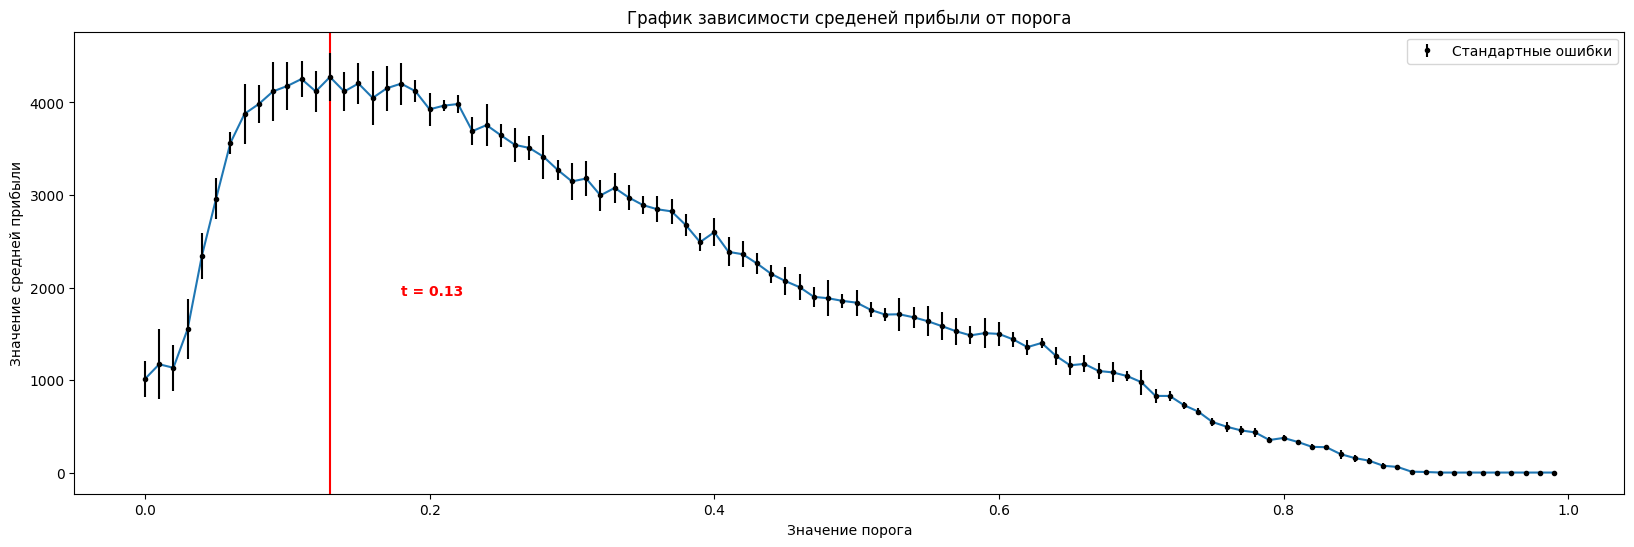

In [130]:
fig, ax = plt.subplots(1, figsize=(20, 6))


ax.plot(t, mean_t)
ax.set_xlabel('Значение порога')
ax.set_ylabel('Значение средней прибыли')
ax.set_title('График зависимости среденей прибыли от порога')
ax.axvline(x=best_t, color='red')
ax.text(x=best_t + 0.05, y=np.mean(mean_t), s=f't = {best_t}', weight='bold', color='red')
ax.errorbar(t, mean_t, yerr=std_t, fmt='.k', label='Стандартные ошибки')
ax.legend()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Сначала, с ростом порога прибыль растет, а потом, чем выше порог, тем ниже прибыль (падает presicion, расте recall). Почему пресижн важнее реколла уже объяснил, но при этом реколл маленьким не может быть, т.к. хоть мы и редко ошибаемся, но при этом и малому количеству клиентов звоним, поэтому лучше увеличить долю клиентов, которым звоним, при этом потеряв немного в точности, но прибыль вырастет

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [133]:
from sklearn.metrics import precision_score, recall_score

In [134]:
precision = []
recall = []
for train_i, test_i in kfold.split(X, y):
    X_train = X.loc[train_i]
    y_train = y.loc[train_i]
    X_test = X.loc[test_i]
    y_test = y.loc[test_i]

    model = pipeline.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    y_pred = np.apply_along_axis(lambda x: 1 if x[1] > best_t else 0, 1, preds)
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
print(f'precision: {np.mean(precision)}, std: {np.std(precision)}')
print(f'recall: {np.mean(recall)}, std: {np.std(recall)}')

recision: 0.3712248399475689, std: 0.015070381343616877
recall: 0.6144036559597682, std: 0.02112918246274114


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [136]:
model = pipeline.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]

precision_1, recall_1, _ = precision_recall_curve(y_test, preds)


precision_2 = precision_1[recall_1 >= 0.5]
recall_2 = recall_1[recall_1 >= 0.5]

print(auc(recall_2, precision_2) / auc(recall_1, precision_1))

0.30533504090042196


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here